In [1]:
#load libraries
import pandas as pd
import os as os
import numpy as np
import re
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='jeremielamboley', api_key='Vl2N6wO66g1b8UXimcav')

# display option
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## scraped database from https://www.henleypassportindex.com

In [2]:
# scrapping script here: https://github.com/jeremielamboley/world-passport-power-rank-enriched/blob/master/henley_passport_index_data_collection.ipynb
df_visa_free = pd.read_csv('https://raw.githubusercontent.com/jeremielamboley/henley/master/henley_visa_free_11_01_2019.csv', encoding = "ISO-8859-1")

In [3]:
df_visa_free.rename(columns={'passport': 'passportfrom_alpha_2code'}, inplace=True)
df_visa_free.rename(columns={'to': 'countryto_alpha_2code'}, inplace=True)

In [4]:
df_visa_free.shape

(45173, 3)

In [5]:
df_visa_free['passportfrom_alpha_2code'].nunique()

198

In [6]:
df_visa_free['countryto_alpha_2code'].nunique()

226

In [7]:
# Let's consider the passport holders countries as a country which gives visa-free access
df_visa_free.loc[df_visa_free['passportfrom_alpha_2code'] == df_visa_free['countryto_alpha_2code'], 'visafree'] = 1

In [8]:
# visafree matrix preview
df_visa_free.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree
6149,UG,FW,0
19147,NE,ML,1
12804,TT,TH,0
29652,KG,PW,1
7365,LI,US,1


In [9]:
# Nationals have visa free access to their own countries
df_visa_free[df_visa_free.passportfrom_alpha_2code == df_visa_free.countryto_alpha_2code].head()

,passportfrom_alpha_2code,countryto_alpha_2code,visafree
9,AM,AM,1
234,AG,AG,1
267,AO,AO,1
316,AR,AR,1
351,DZ,DZ,1


## List of world countries with ISO codes
### Source Wikipedia https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
### Project by Radcliff https://gist.github.com/radcliff/f09c0f88344a7fcef373

In [10]:
df_iso = pd.read_csv('https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv', encoding = "utf8")

In [11]:
df_iso.rename(columns={'English short name lower case': 'Country name'}, inplace=True)
df_iso.rename(columns={'Alpha-2 code': 'country_alpha_2code'}, inplace=True)
df_iso.rename(columns={'Alpha-3 code': 'country_alpha_3code'}, inplace=True)
df_iso.rename(columns={'Numeric code': 'country_numeric_code'}, inplace=True)
df_iso = df_iso.drop(['ISO 3166-2'], axis=1)

In [12]:
df_iso.shape

(246, 4)

In [13]:
df_iso.sample(5)

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code
38,Canada,CA,CAN,124
94,Heard Island and McDonald Islands,HM,HMD,334
117,Kuwait,KW,KWT,414
31,British Indian Ocean Territory,IO,IOT,86
216,"Tanzania, United Republic of",TZ,TZA,834


## Add the Regions, Standard country or area codes for statistical use (M49)
## https://unstats.un.org/unsd/methodology/m49/overview/

In [14]:
df_regions = pd.read_csv('https://raw.githubusercontent.com/jeremielamboley/world-passport-power-rank-enriched/master/source_files/UNSD-M49-25-01-2019.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=0)

In [15]:
df_regions.sample(5)

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
44,1,World,2.0,Africa,202.0,Sub-Saharan Africa,11.0,Western Africa,Burkina Faso,854,BFA,x,x,NaN,Developing
197,1,World,150.0,Europe,39.0,Southern Europe,NaN,NaN,Bosnia and Herzegovina,70,BIH,NaN,NaN,NaN,Developed
75,1,World,19.0,Americas,419.0,Latin America and the Caribbean,29.0,Caribbean,Jamaica,388,JAM,NaN,NaN,x,Developing
208,1,World,150.0,Europe,39.0,Southern Europe,NaN,NaN,Slovenia,705,SVN,NaN,NaN,NaN,Developed
19,1,World,2.0,Africa,202.0,Sub-Saharan Africa,14.0,Eastern Africa,Mozambique,508,MOZ,x,NaN,NaN,Developing


In [16]:
df_regions['Developed / Developing Countries'] = np.where(df_regions['Least Developed Countries (LDC)'] == 'x', 'Least Developed', df_regions['Developed / Developing Countries'])

In [17]:
df_regions.sample(5)

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
108,1,World,19.0,Americas,419.0,Latin America and the Caribbean,5.0,South America,South Georgia and the South Sandwich Islands,239,SGS,NaN,NaN,NaN,Developing
73,1,World,19.0,Americas,419.0,Latin America and the Caribbean,29.0,Caribbean,Guadeloupe,312,GLP,NaN,NaN,NaN,Developing
9,1,World,2.0,Africa,202.0,Sub-Saharan Africa,14.0,Eastern Africa,Comoros,174,COM,x,NaN,x,Least Developed
79,1,World,19.0,Americas,419.0,Latin America and the Caribbean,29.0,Caribbean,Saint BarthÃ©lemy,652,BLM,NaN,NaN,NaN,Developing
180,1,World,150.0,Europe,154.0,Northern Europe,830.0,Channel Islands,Jersey,832,JEY,NaN,NaN,NaN,Developed


In [18]:
df_regions = df_regions[['ISO-alpha3 Code','Region Name','Sub-region Name','Developed / Developing Countries']]
df_regions = df_regions.rename(columns={'ISO-alpha3 Code':'country_alpha_3code'})
df_regions.sample(5)

,country_alpha_3code,Region Name,Sub-region Name,Developed / Developing Countries
63,BHS,Americas,Latin America and the Caribbean,Developing
64,BRB,Americas,Latin America and the Caribbean,Developing
22,SYC,Africa,Sub-Saharan Africa,Developing
235,NRU,Oceania,Micronesia,Developing
71,DOM,Americas,Latin America and the Caribbean,Developing


## GDP per countries in USD, 2016, from the United Nations Statistics Division
### Source: http://data.un.org/

In [19]:
df_GDP_UN = pd.read_csv('http://data.un.org/_Docs/SYB/CSV/SYB61_T13_GDP%20and%20GDP%20Per%20Capita.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=1)

In [20]:
# filter the data to GDP in 2016
df_GDP_UN = df_GDP_UN[df_GDP_UN['Series'] == 'GDP in current prices (millions of US dollars)']
df_GDP_UN = df_GDP_UN[df_GDP_UN.Year == 2016]

In [21]:
# Organize the data
df_GDP_UN['Value'] = df_GDP_UN['Value'].str.replace(',', '')
df_GDP_UN['Value'] = df_GDP_UN['Value'].astype(int)
# Renaming columns
df_GDP_UN.rename(columns={'Region/Country/Area': 'country_numeric_code'}, inplace=True)
df_GDP_UN.rename(columns={'Value': 'UN_GDP_currentPrices2016'}, inplace=True)
# Convert GDP from millions to billions
df_GDP_UN['UN_GDP_currentPrices2016_billions'] = df_GDP_UN['UN_GDP_currentPrices2016'] / 1000

In [22]:
df_GDP_UN.shape

(242, 8)

In [23]:
df_GDP_UN.sample(5)

,country_numeric_code,Unnamed: 1,Year,Series,UN_GDP_currentPrices2016,Footnotes,Source,UN_GDP_currentPrices2016_billions
1146,40,Austria,2016,GDP in current prices (millions of US dollars),390800,NaN,"United Nations Statistics Division, New York, ...",390.800
1890,148,Chad,2016,GDP in current prices (millions of US dollars),11267,NaN,"United Nations Statistics Division, New York, ...",11.267
1038,32,Argentina,2016,GDP in current prices (millions of US dollars),545866,NaN,"United Nations Statistics Division, New York, ...",545.866
6488,548,Vanuatu,2016,GDP in current prices (millions of US dollars),838,NaN,"United Nations Statistics Division, New York, ...",0.838
5927,762,Tajikistan,2016,GDP in current prices (millions of US dollars),6952,NaN,"United Nations Statistics Division, New York, ...",6.952


In [24]:
df_GDP_UN = df_GDP_UN[['country_numeric_code','UN_GDP_currentPrices2016_billions']]

### World total GDP for 2016 to get a % of coverage per passport

In [25]:
# country code = 1 for the world aggregate
df_GDP_UN['UN_World_GDP_percent'] = df_GDP_UN['UN_GDP_currentPrices2016_billions'] / df_GDP_UN[df_GDP_UN['country_numeric_code'] == 1].iloc[0,1]

In [26]:
df_GDP_UN.sample(5)

,country_numeric_code,UN_GDP_currentPrices2016_billions,UN_World_GDP_percent
562,150,19026.676,0.251513
6488,548,0.838,0.000011
5575,705,44.709,0.000591
2949,300,192.691,0.002547
758,54,35.782,0.000473


# Population and surface, 2015, from the United Nations Statistics Division

### Source: http://data.un.org/

In [27]:
df_population_surface_UN = pd.read_csv('http://data.un.org/_Docs/SYB/CSV/SYB61_T02_Population,%20Surface%20Area%20and%20Density.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=1)

In [28]:
# filter the data to GDP in 2015
df_population_surface_UN = df_population_surface_UN[(df_population_surface_UN['Series'] == 'Population mid-year estimates (millions)') | (df_population_surface_UN['Series'] == 'Surface area (thousand km2)')]
df_population_surface_UN = df_population_surface_UN[df_population_surface_UN['Year'] == 2015]

In [29]:
# Organize the data
df_population_surface_UN['Value'] = df_population_surface_UN['Value'].str.replace(',', '')
df_population_surface_UN['Value'] = df_population_surface_UN['Value'].astype(float)

In [30]:
df_population_surface_UN = df_population_surface_UN[['Region/Country/Area','Series','Value']]
df_population_surface_UN.rename(columns={'Region/Country/Area': 'country_numeric_code'}, inplace=True)

In [31]:
# pivot and un-pivot
df_population_surface_UN = df_population_surface_UN.pivot(index='country_numeric_code', columns='Series', values='Value')
df_population_surface_UN = pd.DataFrame(df_population_surface_UN.to_records())

In [32]:
# get the world total for population and surface
df_population_UN_world = df_population_surface_UN[(df_population_surface_UN.country_numeric_code == 1)].iloc[0,1]
df_surface_UN_world = df_population_surface_UN[(df_population_surface_UN.country_numeric_code == 1)].iloc[0,2]

In [33]:
# World Population mid-year estimates 7383 millions, 2015
# Source: United Nations Statistics Division, New York, World Population Prospects: The 2017 Revision, last accessed June 2017.
df_population_surface_UN['UN_population_Value_2015_percent'] = (df_population_surface_UN['Population mid-year estimates (millions)'] / df_population_UN_world)

In [34]:
df_population_surface_UN['Surface_area_covered_percent'] = (df_population_surface_UN['Surface area (thousand km2)'] / df_surface_UN_world)

In [35]:
df_population_surface_UN.sample(5)

,country_numeric_code,Population mid-year estimates (millions),Surface area (thousand km2),UN_population_Value_2015_percent,Surface_area_covered_percent
8,13,172.64,2480.0,0.023383,0.018214
87,226,1.18,28.0,0.000160,0.000206
225,748,1.32,17.0,0.000179,0.000125
168,524,28.66,147.0,0.003882,0.001080
192,620,10.42,92.0,0.001411,0.000676


# Unesco World Heritage list 

### https://whc.unesco.org/en/syndication

In [36]:
# Fetch the data from the Unesco website
unesco = pd.read_excel('https://whc.unesco.org/en/list/xls/whc-sites-2018.xls', encoding="Windows-1252",header=0)
unesco = unesco.reindex(['name_en', 'iso_code'], axis="columns")

In [37]:
# check the shape
unesco.shape

(1092, 2)

In [38]:
# Some values are comma separated and need to be reformated
unesco.tail(5)

,name_en,iso_code
1087,Prehistoric Rock Art Sites in the Côa Valley a...,"pt,es"
1088,Uvs Nuur Basin,"ru,mn"
1089,Landscapes of Dauria,"ru,mn"
1090,Heritage of Mercury. Almadén and Idrija,"si,es"
1091,Mosi-oa-Tunya / Victoria Falls,"zm,zw"


In [39]:
# Split the values
unesco = pd.concat([unesco['name_en'], unesco['iso_code'].str.split(',', expand=True)], axis=1)

unesco2 = []
for i in range(0,11):
    temp = unesco.loc[:,['name_en',i]]
    temp.columns = ['name_en','countryto_alpha_2code']
    unesco2.append(temp)
unesco2 = pd.concat(unesco2, ignore_index=True)

# Remove empty values
unesco2 = unesco2.replace(to_replace='None', value=np.nan).dropna().reset_index(drop=True)
# preview
unesco2.sample(5)

,name_en,countryto_alpha_2code
266,Abu Mena,eg
788,Virgin Komi Forests,ru
368,Caves and Ice Age Art in the Swabian Jura,de
776,Churches of Moldavia,ro
1105,Silk Roads: the Routes Network of Chang'an-Tia...,kz


In [40]:
# create a pivot table
unesco_pivot = pd.pivot_table(unesco2,index=['countryto_alpha_2code'], aggfunc='count')
unesco_pivot = pd.DataFrame(unesco_pivot.to_records())
unesco_pivot = unesco_pivot.rename(columns = {'name_en' :'unesco_total_sites'})
unesco_pivot = unesco_pivot.sort_values('unesco_total_sites',ascending=False)

In [41]:
# Count the total of world unesco sites
unesco_total_sites = unesco_pivot['unesco_total_sites'].sum()
# create the % of sites located in each country
unesco_pivot['unesco_total_sites_percent'] = (unesco_pivot['unesco_total_sites'] / unesco_total_sites)

In [42]:
# change to uppercase
unesco_pivot['countryto_alpha_2code'] = unesco_pivot['countryto_alpha_2code'].str.upper()

In [43]:
unesco_pivot.sample(5)

,countryto_alpha_2code,unesco_total_sites,unesco_total_sites_percent
43,DZ,7,0.006003
82,KP,2,0.001715
34,CR,4,0.003431
76,JP,22,0.018868
25,CD,5,0.004288


## Intersect df_iso and df_regions

In [44]:
df_iso = pd.merge(df_iso, df_regions, how='left', on='country_alpha_3code')
df_iso.sample(5)

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries
44,China,CN,CHN,156,Asia,Eastern Asia,Developing
82,Gibraltar,GI,GIB,292,Europe,Southern Europe,Developed
68,Ethiopia,ET,ETH,231,Africa,Sub-Saharan Africa,Least Developed
169,Panama,PA,PAN,591,Americas,Latin America and the Caribbean,Developing
149,Mozambique,MZ,MOZ,508,Africa,Sub-Saharan Africa,Least Developed


## Intersect df_visa_free and df_iso on 'country to'

In [45]:
# copy df_visa_free, rename the columns from centadata and hauntedhouse
df_visa_free2 = df_visa_free.copy()

In [46]:
df_visa_free2.rename(columns={'countryto_alpha_2code': 'country_alpha_2code'}, inplace=True)

In [47]:
# Intersect on 'countryto_alpha_2code'
df = pd.merge(df_visa_free2, df_iso, on=['country_alpha_2code'], how='left')

In [48]:
df.rename(columns={'country_alpha_2code': 'countryto_alpha_2code'}, inplace=True)
df.rename(columns={'Country name': 'countryto_Country_name'}, inplace=True)
df.rename(columns={'country_alpha_3code': 'countryto_country_alpha_3code'}, inplace=True)
df.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)
df.rename(columns={'Region Name': 'countryto_Region_Name'}, inplace=True)
df.rename(columns={'Sub-region Name': 'countryto_Sub-region_Name'}, inplace=True)
df.rename(columns={'Developed / Developing Countries': 'countryto_Developed_Developing_Countries'}, inplace=True)

In [49]:
df['passportfrom_alpha_2code'].nunique()

198

In [50]:
df['countryto_alpha_2code'].nunique()

226

In [51]:
cols = df.columns.tolist()
cols

['passportfrom_alpha_2code',
 'countryto_alpha_2code',
 'visafree',
 'countryto_Country_name',
 'countryto_country_alpha_3code',
 'countryto_country_numeric_code',
 'countryto_Region_Name',
 'countryto_Sub-region_Name',
 'countryto_Developed_Developing_Countries']

In [52]:
df.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries
8367,ZM,ZM,1,Zambia,ZMB,894.0,Africa,Sub-Saharan Africa,Least Developed
27295,MO,MN,1,Mongolia,MNG,496.0,Asia,Eastern Asia,Developing
3289,GB,AL,1,Albania,ALB,8.0,Europe,Southern Europe,Developed
34053,CR,BZ,1,Belize,BLZ,84.0,Americas,Latin America and the Caribbean,Developing
6838,SM,KR,1,"Korea, Republic of",KOR,410.0,Asia,Eastern Asia,Developing


## Intersect df_visa_free and df_iso on 'passport'

In [53]:
df_iso.rename(columns={'country_alpha_2code': 'passportfrom_alpha_2code'}, inplace=True)

In [54]:
# Intersect on 'passportfrom_alpha_2code'
df = pd.merge(df, df_iso, on=['passportfrom_alpha_2code'], how='left')

In [55]:
df_iso.rename(columns={'passportfrom_alpha_2code': 'country_alpha_2code'}, inplace=True)

In [56]:
# 
df.rename(columns={'Country name': 'passportfrom_Country_name'}, inplace=True)
df.rename(columns={'Region Name': 'passportfrom_Region_Name'}, inplace=True)
df.rename(columns={'Sub-region Name': 'passportfrom_Sub-region_Name'}, inplace=True)
df.rename(columns={'Developed / Developing Countries': 'passportfrom_Developed_Developing_Countries'}, inplace=True)

In [57]:
df = df.drop(['country_alpha_3code'], axis=1)
df = df.drop(['country_numeric_code'], axis=1)

In [58]:
df.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries,passportfrom_Country_name,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries
39594,ET,MH,0,Marshall Islands,MHL,584.0,Oceania,Micronesia,Developing,Ethiopia,Africa,Sub-Saharan Africa,Least Developed
40122,CO,JP,0,Japan,JPN,392.0,Asia,Eastern Asia,Developed,Colombia,Americas,Latin America and the Caribbean,Developing
23566,NG,VI,0,"Virgin Islands, U.S.",VIR,850.0,Americas,Latin America and the Caribbean,Developing,Nigeria,Africa,Sub-Saharan Africa,Developing
25846,JM,FR,0,France,FRA,250.0,Europe,Western Europe,Developed,Jamaica,Americas,Latin America and the Caribbean,Developing
10575,SD,KZ,0,Kazakhstan,KAZ,398.0,Asia,Central Asia,Developing,Sudan,Africa,Northern Africa,Least Developed


## Intersect df and df_GDP_UN

In [59]:
df_GDP_UN2 = df_GDP_UN.copy()
df_GDP_UN2.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [60]:
df2 = pd.merge(df, df_GDP_UN2, on=['countryto_country_numeric_code'], how='left')

In [61]:
df2.rename(columns={'UN_GDP_currentPrices2016_billions': 'countryto_UN_GDP_currentPrices2016'}, inplace=True)

In [62]:
df2.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries,passportfrom_Country_name,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent
12908,TJ,PT,0,Portugal,PRT,620.0,Europe,Southern Europe,Developed,Tajikistan,Asia,Central Asia,Developing,204.837,0.002708
885,BA,BB,0,Barbados,BRB,52.0,Americas,Latin America and the Caribbean,Developing,Bosnia and Herzegovina,Europe,Southern Europe,Developed,4.553,0.000060
31743,MV,VI,0,"Virgin Islands, U.S.",VIR,850.0,Americas,Latin America and the Caribbean,Developing,Maldives,Asia,Southern Asia,Developing,NaN,NaN
21359,KI,AS,0,American Samoa,ASM,16.0,Oceania,Polynesia,Developing,Kiribati,Oceania,Micronesia,Least Developed,NaN,NaN
25121,JM,CZ,0,Czech Republic,CZE,203.0,Europe,Eastern Europe,Developed,Jamaica,Americas,Latin America and the Caribbean,Developing,195.305,0.002582


## Intersect df2 and df_population_UN

In [63]:
df_population_UN2 = df_population_surface_UN.copy()
df_population_UN2.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [64]:
df3 = pd.merge(df2, df_population_UN2, on=['countryto_country_numeric_code'], how='left')

In [65]:
df3.rename(columns={'UN_population_Value_2015_millions': 'countryto_UN_population_Value_2015_millions'}, inplace=True)
df3.rename(columns={'Population mid-year estimates (millions)': 'countryto_UN_population_Value_2015_millions'}, inplace=True)
df3.rename(columns={'Surface area (thousand km2)': 'countryto_Surface_area'}, inplace=True)

In [66]:
df3.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries,passportfrom_Country_name,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,countryto_Surface_area,UN_population_Value_2015_percent,Surface_area_covered_percent
14532,PT,DJ,1,Djibouti,DJI,262.0,Africa,Sub-Saharan Africa,Least Developed,Portugal,Europe,Southern Europe,Developed,1.892,0.000025,0.93,23.0,0.000126,0.000169
22707,KP,ES,0,Spain,ESP,724.0,Europe,Southern Europe,Developed,"Korea, Democratic People's Republic of",Asia,Eastern Asia,Developing,1237.255,0.016355,46.40,506.0,0.006285,0.003716
6377,VC,AS,0,American Samoa,ASM,16.0,Oceania,Polynesia,Developing,Saint Vincent and the Grenadines,Americas,Latin America and the Caribbean,Developing,NaN,NaN,0.06,0.0,0.000008,0.000000
7612,KN,BR,1,Brazil,BRA,76.0,Americas,Latin America and the Caribbean,Developing,Saint Kitts and Nevis,Americas,Latin America and the Caribbean,Developing,1795.926,0.023740,205.96,8516.0,0.027896,0.062543
15941,NG,DO,0,Dominican Republic,DOM,214.0,Americas,Latin America and the Caribbean,Developing,Nigeria,Africa,Sub-Saharan Africa,Developing,71.584,0.000946,10.53,49.0,0.001426,0.000360


## Intersect df3 and unesco_pivot

In [67]:
unesco_pivot2 = unesco_pivot.copy()

In [68]:
df4 = pd.merge(df3, unesco_pivot2, on=['countryto_alpha_2code'], how='left')

In [69]:
df4.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries,passportfrom_Country_name,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,countryto_Surface_area,UN_population_Value_2015_percent,Surface_area_covered_percent,unesco_total_sites,unesco_total_sites_percent
9779,TL,MX,0,Mexico,MEX,484.0,Americas,Latin America and the Caribbean,Developing,Timor-Leste,Asia,South-eastern Asia,Least Developed,1076.914,0.014236,125.89,1964.0,0.017051,0.014424,35.0,0.030017
20049,MU,AO,1,Angola,AGO,24.0,Africa,Sub-Saharan Africa,Least Developed,Mauritius,Africa,Sub-Saharan Africa,Developing,106.918,0.001413,27.86,1247.0,0.003774,0.009158,1.0,0.000858
14192,SO,LU,0,Luxembourg,LUX,442.0,Europe,Western Europe,Developed,Somalia,Africa,Sub-Saharan Africa,Least Developed,58.631,0.000775,0.57,3.0,0.000077,0.000022,1.0,0.000858
22867,JO,BB,0,Barbados,BRB,52.0,Americas,Latin America and the Caribbean,Developing,Jordan,Asia,Western Asia,Developing,4.553,0.000060,0.28,0.0,0.000038,0.000000,1.0,0.000858
24905,JP,DM,1,Dominica,DMA,212.0,Americas,Latin America and the Caribbean,Developing,Japan,Asia,Eastern Asia,Developed,0.581,0.000008,0.07,1.0,0.000009,0.000007,1.0,0.000858


## Reordering the columns

In [70]:
df4 = df4.reset_index(drop=True)
cols = df4.columns.tolist()
cols

['passportfrom_alpha_2code',
 'countryto_alpha_2code',
 'visafree',
 'countryto_Country_name',
 'countryto_country_alpha_3code',
 'countryto_country_numeric_code',
 'countryto_Region_Name',
 'countryto_Sub-region_Name',
 'countryto_Developed_Developing_Countries',
 'passportfrom_Country_name',
 'passportfrom_Region_Name',
 'passportfrom_Sub-region_Name',
 'passportfrom_Developed_Developing_Countries',
 'countryto_UN_GDP_currentPrices2016',
 'UN_World_GDP_percent',
 'countryto_UN_population_Value_2015_millions',
 'countryto_Surface_area',
 'UN_population_Value_2015_percent',
 'Surface_area_covered_percent',
 'unesco_total_sites',
 'unesco_total_sites_percent']

In [71]:
df4 = df4[['passportfrom_alpha_2code','passportfrom_Country_name','passportfrom_Sub-region_Name','countryto_alpha_2code','countryto_Country_name','countryto_country_alpha_3code', 'countryto_country_numeric_code','countryto_UN_GDP_currentPrices2016','UN_World_GDP_percent', 'countryto_UN_population_Value_2015_millions','UN_population_Value_2015_percent','countryto_Surface_area','Surface_area_covered_percent','unesco_total_sites','unesco_total_sites_percent','visafree']]

In [72]:
df4['passportfrom_alpha_2code'].nunique()

198

In [73]:
df4.head(5)

,passportfrom_alpha_2code,passportfrom_Country_name,passportfrom_Sub-region_Name,countryto_alpha_2code,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,UN_population_Value_2015_percent,countryto_Surface_area,Surface_area_covered_percent,unesco_total_sites,unesco_total_sites_percent,visafree
0,AM,Armenia,Western Asia,AF,Afghanistan,AFG,4.0,20.235,0.000267,33.74,0.004570,653.0,0.004796,2.0,0.001715,0
1,AM,Armenia,Western Asia,AL,Albania,ALB,8.0,11.864,0.000157,2.92,0.000396,29.0,0.000213,3.0,0.002573,1
2,AM,Armenia,Western Asia,DZ,Algeria,DZA,12.0,159.049,0.002102,39.87,0.005400,2382.0,0.017494,7.0,0.006003,0
3,AM,Armenia,Western Asia,AS,American Samoa,ASM,16.0,NaN,NaN,0.06,0.000008,0.0,0.000000,NaN,NaN,0
4,AM,Armenia,Western Asia,AD,Andorra,AND,20.0,2.858,0.000038,0.08,0.000011,0.0,0.000000,1.0,0.000858,0


## Pandas pivot_table 'passport FROM'

In [74]:
df_pivot = pd.pivot_table(df4[df4.visafree == 1],index='passportfrom_Country_name',values=['countryto_UN_GDP_currentPrices2016','UN_World_GDP_percent','countryto_UN_population_Value_2015_millions','UN_population_Value_2015_percent','countryto_Surface_area','Surface_area_covered_percent','unesco_total_sites','unesco_total_sites_percent','visafree'], aggfunc=np.sum, margins=False,dropna=True)
df_pivot.sort_values('visafree', ascending=False)
df_pivot.head(5)

,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree
passportfrom_Country_name,,,,,,,,,
Afghanistan,0.043228,0.006096,0.053354,5886.0,461.147,393.91,41.0,0.035163,31
Albania,0.235925,0.304711,0.269534,32124.0,23051.078,1989.97,640.0,0.548885,116
Algeria,0.126034,0.040480,0.132256,17161.0,3062.282,976.45,164.0,0.140652,51
Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170
Angola,0.123030,0.044224,0.153492,16752.0,3345.458,1133.23,141.0,0.120926,50


## Turn the pivot table in a Data frame

In [75]:
df_pivot_flattened = pd.DataFrame(df_pivot.to_records())
df_pivot_flattened.sample(5)

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree
151,San Marino,0.608062,0.905786,0.607061,82795.0,68521.709,4481.94,959.0,0.822470,169
168,Swaziland,0.118895,0.079574,0.165167,16189.0,6019.701,1219.43,177.0,0.151801,73
64,Ghana,0.125123,0.044335,0.175709,17037.0,3353.873,1297.26,143.0,0.122642,64
138,Paraguay,0.447937,0.406684,0.364793,60992.0,30765.198,2693.27,808.0,0.692967,144
20,"Bolivia, Plurinational State of",0.364588,0.137038,0.252264,49643.0,10366.800,1862.47,283.0,0.242710,80


## Pandas pivot_table 'passport TO'

In [76]:
df_pivot2 = pd.pivot_table(df4[df4.visafree == 1],index='countryto_Country_name',values=['visafree'], aggfunc=np.sum, margins=False,dropna=True)
df_pivot_flattened2 = pd.DataFrame(df_pivot2.to_records())
df_pivot_flattened2.rename(columns = {'countryto_Country_name':'passportfrom_Country_name','visafree':'visafreeTO'}, inplace=True)
df_pivot_flattened = pd.merge(df_pivot_flattened, df_pivot_flattened2, how='left', on='passportfrom_Country_name')
df_pivot_flattened.head()

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO
0,Afghanistan,0.043228,0.006096,0.053354,5886.0,461.147,393.91,41.0,0.035163,31,1
1,Albania,0.235925,0.304711,0.269534,32124.0,23051.078,1989.97,640.0,0.548885,116,90
2,Algeria,0.126034,0.040480,0.132256,17161.0,3062.282,976.45,164.0,0.140652,51,8
3,Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170,94
4,Angola,0.123030,0.044224,0.153492,16752.0,3345.458,1133.23,141.0,0.120926,50,12


In [77]:
df_pivot_flattened['Surface_Rank'] = df_pivot_flattened['countryto_Surface_area'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['GDP_Rank'] = df_pivot_flattened['countryto_UN_GDP_currentPrices2016'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['Population_Rank'] = df_pivot_flattened['countryto_UN_population_Value_2015_millions'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['visafree_countries_Rank'] = df_pivot_flattened['visafree'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['unesco_total_sites_Rank'] = df_pivot_flattened['unesco_total_sites'].rank(method='min', ascending=False).astype(int)

## Calculate the overall ranking

In [78]:
df_pivot_flattened['Overall_ranking_calculation'] = df_pivot_flattened[['visafree_countries_Rank','GDP_Rank','Surface_Rank','Population_Rank','unesco_total_sites_Rank']].sum(axis=1)

In [79]:
df_pivot_flattened['New_Overall_ranking'] = df_pivot_flattened['Overall_ranking_calculation'].rank(method='min', ascending=True).astype(int)

In [80]:
df_pivot_flattened

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking
0,Afghanistan,0.043228,0.006096,0.053354,5886.0,461.147,393.91,41.0,0.035163,31,1,197,197,196,196,197,983,197
1,Albania,0.235925,0.304711,0.269534,32124.0,23051.078,1989.97,640.0,0.548885,116,90,109,91,97,93,91,481,97
2,Algeria,0.126034,0.040480,0.132256,17161.0,3062.282,976.45,164.0,0.140652,51,8,146,169,172,168,139,794,161
3,Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170,94,30,20,41,42,28,161,30
4,Angola,0.123030,0.044224,0.153492,16752.0,3345.458,1133.23,141.0,0.120926,50,12,150,166,162,170,160,808,165
5,Antigua and Barbuda,0.280937,0.354557,0.314434,38253.0,26821.807,2321.47,736.0,0.631218,151,106,95,81,85,57,73,391,77
6,Argentina,0.511721,0.491998,0.406577,69677.0,37219.055,3001.76,905.0,0.776158,171,88,37,55,50,41,33,216,44
7,Armenia,0.332237,0.092399,0.194449,45238.0,6989.850,1435.62,227.0,0.194683,62,134,88,125,127,138,119,597,118
8,Australia,0.509636,0.725889,0.396100,69393.0,54912.695,2924.41,891.0,0.764151,182,35,40,38,54,25,40,197,41
9,Austria,0.577826,0.750910,0.430147,78678.0,56805.512,3175.78,920.0,0.789022,186,94,18,24,33,12,19,106,18


In [81]:
df_iso

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries
0,Afghanistan,AF,AFG,4,Asia,Southern Asia,Least Developed
1,Åland Islands,AX,ALA,248,Europe,Northern Europe,Developed
2,Albania,AL,ALB,8,Europe,Southern Europe,Developed
3,Algeria,DZ,DZA,12,Africa,Northern Africa,Developing
4,American Samoa,AS,ASM,16,Oceania,Polynesia,Developing
5,Andorra,AD,AND,20,Europe,Southern Europe,Developed
6,Angola,AO,AGO,24,Africa,Sub-Saharan Africa,Least Developed
7,Anguilla,AI,AIA,660,Americas,Latin America and the Caribbean,Developing
8,Antarctica,AQ,ATA,10,NaN,NaN,NaN
9,Antigua and Barbuda,AG,ATG,28,Americas,Latin America and the Caribbean,Developing


In [82]:
df_iso.rename(columns={'Country name': 'passportfrom_Country_name'}, inplace=True)
df_pivot_flattened = pd.merge(df_pivot_flattened, df_iso, how='left', on='passportfrom_Country_name')

In [83]:
df_pivot_flattened['visaFreeRatio'] = round((df_pivot_flattened['visafree'] / df_pivot_flattened['visafreeTO']).astype(float),1)

In [84]:
# Re-order and format the values
df_pivot_flattened.sort_values('New_Overall_ranking',ascending=True, inplace=True)
df_pivot_flattened = df_pivot_flattened.reset_index(drop=True)
df_pivot_flattened.sample(5).style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_covered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries,visaFreeRatio
36,Slovenia,50.22%,74.00%,41.58%,68376,55982.4,3069.72,899,77.10%,181,94,41,34,46,28,36,185,36,SI,SVN,705,Europe,Southern Europe,Developed,1.9
159,Turkmenistan,10.04%,5.00%,14.88%,13673,3782.64,1098.34,159,13.64%,54,2,177,149,166,159,141,792,160,TM,TKM,795,Asia,Central Asia,Developing,27
142,Haiti,12.26%,7.82%,17.14%,16697,5914.51,1265.39,172,14.75%,52,194,151,128,144,165,136,724,143,HT,HTI,332,Americas,Latin America and the Caribbean,Least Developed,0.3
162,Viet Nam,10.94%,5.16%,15.20%,14898,3899.97,1122.42,141,12.09%,52,26,165,147,164,165,160,801,163,VN,VNM,704,Asia,South-eastern Asia,Developing,2
76,Antigua and Barbuda,28.09%,35.46%,31.44%,38253,26821.8,2321.47,736,63.12%,151,106,95,81,85,57,73,391,77,AG,ATG,28,Americas,Latin America and the Caribbean,Developing,1.4


## The average passport rank by continent and sub-region

In [85]:
df_pivot_flattened.rename(columns={'Sub-region Name': 'passportfrom_Sub-region_Name'}, inplace=True)
df_pivot_flattened.rename(columns={'Region Name': 'passportfrom_Region_Name'}, inplace=True)
df_pivot_flattened.rename(columns={'Developed / Developing Countries': 'passportfrom_Developed_Developing_Countries'}, inplace=True)

In [86]:
df_pivot_flattened_continent = df_pivot_flattened.groupby(by="passportfrom_Region_Name")
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="passportfrom_Sub-region_Name")

In [87]:
# Median passport rank by continent
df_pivot_flattened_continent['New_Overall_ranking'].median().sort_values()

passportfrom_Region_Name
Europe       28.5
Americas     70.0
Oceania      85.0
Asia        120.5
Africa      156.0
Name: New_Overall_ranking, dtype: float64

In [88]:
# Standard deviation by continent
df_pivot_flattened_continent = df_pivot_flattened.groupby(by="passportfrom_Region_Name")
df_pivot_flattened_continent['New_Overall_ranking'].std().sort_values()

passportfrom_Region_Name
Oceania     26.363478
Europe      27.204835
Americas    28.576802
Africa      29.763143
Asia        55.925110
Name: New_Overall_ranking, dtype: float64

In [89]:
# Ratio countries welcomed vs countries welcoming by sub-region
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="passportfrom_Sub-region_Name")
df_pivot_flattened_subRegion['visaFreeRatio'].mean().sort_values()

passportfrom_Sub-region_Name
Polynesia                          1.000000
South-eastern Asia                 1.190909
Melanesia                          1.200000
Latin America and the Caribbean    1.366667
Southern Europe                    1.700000
Eastern Europe                     1.770000
Western Europe                     1.977778
Northern Europe                    1.990000
Micronesia                         2.000000
Sub-Saharan Africa                 2.025532
Western Asia                       2.866667
Northern America                   3.850000
Australia and New Zealand          4.050000
Northern Africa                    4.400000
Central Asia                       6.560000
Southern Asia                      7.144444
Eastern Asia                       8.028571
Name: visaFreeRatio, dtype: float64

In [90]:
# country access by sub-region
df_pivot_flattened_subRegion_access = df_pivot_flattened_subRegion[['visafree','visafreeTO']].mean().astype(int)
df_pivot_flattened_subRegion_access['visaFreeRatio2'] = round(df_pivot_flattened_subRegion['visafree'].mean() / df_pivot_flattened_subRegion['visafreeTO'].mean().astype(float),1)
df_pivot_flattened_subRegion_access.sort_values('visaFreeRatio2',ascending=False)

,visafree,visafreeTO,visaFreeRatio2
passportfrom_Sub-region_Name,,,
Australia and New Zealand,182,48,3.8
Northern America,185,49,3.8
Northern Europe,184,92,2.0
Western Europe,184,94,2.0
Eastern Europe,151,87,1.7
Southern Europe,158,93,1.7
Eastern Asia,125,79,1.6
Central Asia,62,49,1.3
Latin America and the Caribbean,129,111,1.2


In [91]:
# Median passport rank by sub-region
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="passportfrom_Sub-region_Name")
df_pivot_flattened_subRegion['New_Overall_ranking'].median().astype(int).sort_values()

passportfrom_Sub-region_Name
Western Europe                      18
Northern Europe                     22
Australia and New Zealand           33
Southern Europe                     36
Northern America                    39
Eastern Europe                      53
Eastern Asia                        60
Latin America and the Caribbean     72
Polynesia                           83
Micronesia                          87
Melanesia                           91
South-eastern Asia                 116
Western Asia                       119
Central Asia                       130
Sub-Saharan Africa                 155
Northern Africa                    167
Southern Asia                      181
Name: New_Overall_ranking, dtype: int32

## Rank by sub-regions

In [92]:
df_pivot_flattened['ranking_bySubRegion'] = df_pivot_flattened.groupby('passportfrom_Sub-region_Name')['Overall_ranking_calculation'].rank(method='min', ascending=True).astype(int)

In [93]:
df_pivot_flattened.head(5).sort_values(['passportfrom_Sub-region_Name','ranking_bySubRegion'], ascending=[True,True])

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking,country_alpha_2code,country_alpha_3code,country_numeric_code,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,visaFreeRatio,ranking_bySubRegion
0,Japan,0.636426,0.921710,0.802333,86657.0,69726.300,5923.63,1024.0,0.878216,191,68,4,1,1,1,1,8,1,JP,JPN,392,Asia,Eastern Asia,Developed,2.8,1
2,"Korea, Republic of",0.737394,0.813333,0.660625,100405.0,61527.752,4877.40,1017.0,0.872213,190,111,1,6,2,2,2,13,3,KR,KOR,410,Asia,Eastern Asia,Developing,1.7,2
1,Singapore,0.668116,0.913151,0.643647,90972.0,69078.830,4752.05,1009.0,0.865352,190,164,2,2,3,2,3,12,2,SG,SGP,702,Asia,South-eastern Asia,Developing,1.2,1
3,France,0.589313,0.765937,0.457618,80242.0,57942.279,3378.60,951.0,0.815609,189,94,9,7,16,4,5,41,4,FR,FRA,250,Europe,Western Europe,Developed,2.0,1
4,Germany,0.597502,0.765189,0.453826,81357.0,57885.660,3350.60,951.0,0.815609,189,94,8,8,17,4,5,42,5,DE,DEU,276,Europe,Western Europe,Developed,2.0,2


## Create a new column Gain/loss in ranking

In [94]:
df_pivot_flattened['gain-loss'] = df_pivot_flattened['visafree_countries_Rank'] - df_pivot_flattened['New_Overall_ranking']

In [125]:
df_pivot_flattened['gain-loss'].median()

-1.0

In [95]:
df_pivot_flattened.sample(5)

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking,country_alpha_2code,country_alpha_3code,country_numeric_code,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,visaFreeRatio,ranking_bySubRegion,gain-loss
19,Austria,0.577826,0.750910,0.430147,78678.0,56805.512,3175.78,920.0,0.789022,186,94,18,24,33,12,19,106,18,AT,AUT,40,Europe,Western Europe,Developed,2.0,5,-6
158,Mozambique,0.120952,0.047489,0.154956,16469.0,3592.517,1144.04,132.0,0.113208,59,199,153,161,159,143,172,788,159,MZ,MOZ,508,Africa,Sub-Saharan Africa,Least Developed,0.3,28,-16
117,Kyrgyzstan,0.269392,0.074655,0.200497,36681.0,5647.571,1480.27,229.0,0.196398,65,82,97,129,120,133,118,597,118,KG,KGZ,417,Asia,Central Asia,Developing,0.8,2,15
149,Bhutan,0.113446,0.057349,0.171578,15447.0,4338.363,1266.76,157.0,0.134648,56,4,162,139,143,152,143,739,150,BT,BTN,64,Asia,Southern Asia,Least Developed,14.0,4,2
24,New Zealand,0.567001,0.756958,0.426848,77204.0,57263.030,3151.42,919.0,0.788165,182,62,26,21,39,25,24,135,25,NZ,NZL,554,Oceania,Australia and New Zealand,Developed,2.9,1,0


## Reorder the columns

In [96]:
df_final = df_pivot_flattened[['passportfrom_Country_name',
                                         'country_alpha_3code',
                                         'New_Overall_ranking',
                                         'gain-loss',
                                         'visafree',
                                         'visafree_countries_Rank',
                                         'countryto_UN_GDP_currentPrices2016',
                                         'GDP_Rank',
                                         'UN_World_GDP_percent',
                                         'countryto_UN_population_Value_2015_millions',
                                         'Population_Rank',
                                         'UN_population_Value_2015_percent',
                                         'countryto_Surface_area',
                                         'Surface_Rank',
                                         'Surface_area_covered_percent',
                                         'unesco_total_sites',
                                         'unesco_total_sites_percent',
                                         'unesco_total_sites_Rank',
                                         'Overall_ranking_calculation',
                                         'passportfrom_Region_Name',
                                         'passportfrom_Sub-region_Name',
                                         'passportfrom_Developed_Developing_Countries',
                                         'visafreeTO',
                                         'visaFreeRatio',
                                         'ranking_bySubRegion']]

In [97]:
# Export to CSV
df_final.to_csv('ranking.csv')

## Biggest winners and losers

In [98]:
df_rankgainloss = df_pivot_flattened[['passportfrom_Country_name','gain-loss']].sort_values('gain-loss', ascending=False, inplace=False)
df_rankgainloss.head(5).style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_covered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,gain-loss
146,Nepal,41
9,San Marino,36
77,Belarus,34
58,Bosnia and Herzegovina,32
16,Brunei Darussalam,31


In [99]:
df_rankgainloss.tail(5).style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_covered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,gain-loss
127,Nauru,-25
38,United States,-27
89,Saint Lucia,-28
163,Uganda,-31
171,Sierra Leone,-33


# A little program to access the results easily

In [100]:
# create a new list
countrylist = list(set(df_final['passportfrom_Country_name'].drop_duplicates().values.tolist()))
countrylist.sort()

In [101]:
# Select the passport holder's country with drop drop menu
countryselected = widgets.Dropdown(
    options=countrylist,
    value='Hong Kong',
    description="Country:",
    disabled=False)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print ("Country selected: %s" % change['new'])

countryselected.observe(on_change)
display(countryselected)

Dropdown(description='Country:', index=74, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', …

In [102]:
# the number of destinations accessible visa-free
countryselectedvisafree = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['visafree']
countryselectedvisafree = countryselectedvisafree.to_frame()
countryselectedvisafree = countryselectedvisafree.iloc[0]['visafree']
# the overall country rank
countryrank = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['New_Overall_ranking']
countryrank = countryrank.to_frame()
countryrank = countryrank.iloc[0]['New_Overall_ranking']
# the gain-loss compare the to Henley Passport Index 
gainloss = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['gain-loss']
gainloss = gainloss.to_frame()
gainloss = gainloss.iloc[0]['gain-loss']
# the rank regarding the number of countries accessible visa-free
visafreecountriesRank = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['visafree_countries_Rank']
visafreecountriesRank = visafreecountriesRank.to_frame()
visafreecountriesRank = visafreecountriesRank.iloc[0]['visafree_countries_Rank']
# the rank regarding to the population accessible visa-free
countryselectedpopulation = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['UN_population_Value_2015_percent']
countryselectedpopulation = countryselectedpopulation.to_frame()
countryselectedpopulation = countryselectedpopulation.iloc[0]['UN_population_Value_2015_percent']
# the rank regarding to the globe surface accessible visa-free
countryselectedsurface = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['Surface_area_covered_percent']
countryselectedsurface = countryselectedsurface.to_frame()
countryselectedsurface = countryselectedsurface.iloc[0]['Surface_area_covered_percent']
countryselectedsurface = countryselectedsurface.item()
# the rank regarding to the world GDP accessible visa-free
countryselectedGDP = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['UN_World_GDP_percent']
countryselectedGDP = countryselectedGDP.to_frame()
countryselectedGDP = countryselectedGDP.iloc[0]['UN_World_GDP_percent']
# the rank regarding to the number of unesco sites accessible visa-free
countryselectedUnesco = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['unesco_total_sites_percent']
countryselectedUnesco = countryselectedUnesco.to_frame()
countryselectedUnesco = countryselectedUnesco.iloc[0]['unesco_total_sites_percent']

# Run this query to get the statistics
def country_access(countryselected,countryselectedvisafree,countryrank,visafreecountriesRank,gainloss,countryselectedpopulation,countryselectedsurface,countryselectedGDP,countryselectedUnesco):
    print(countryselected.value + "'s passport gives you access to:")
    print("\n" + str(countryselectedvisafree) + " destinations visa-free (over " + str(df_visa_free['countryto_alpha_2code'].nunique()) + " possible), covering:")
    print("\t" + "{:.0%}".format(countryselectedpopulation) + " of the world's population")
    print("\t" + "{:.0%}".format(countryselectedsurface) + " of the world's surface")
    print("\t" + "{:.0%}".format(countryselectedGDP) + " of the world's GPD")
    print("\t" + "{:.0%}".format(countryselectedUnesco) + " of the world's Unesco World heritage sites")
    print("\nIt ranks " + str(countryrank)  +  " over " + str(df_final['passportfrom_Country_name'].nunique()) + " countries' passports according to these 5 criteria.")
    print("It's a " + str(np.where(gainloss < 0, "rank loss of "+str(gainloss), "rank gain of +" + str(gainloss))) + " compare to the traditional Henley Passport Index (ranked " + str(visafreecountriesRank) + ").")
country_access(countryselected,countryselectedvisafree,countryrank,visafreecountriesRank,gainloss,countryselectedpopulation,countryselectedsurface,countryselectedGDP,countryselectedUnesco)

Hong Kong's passport gives you access to:

170 destinations visa-free (over 226 possible), covering:
	40% of the world's population
	65% of the world's surface
	53% of the world's GPD
	79% of the world's Unesco World heritage sites

It ranks 34 over 197 countries' passports according to these 5 criteria.
It's a rank gain of +8 compare to the traditional Henley Passport Index (ranked 42).


In [103]:
df_final.head(10)

,passportfrom_Country_name,country_alpha_3code,New_Overall_ranking,gain-loss,visafree,visafree_countries_Rank,countryto_UN_GDP_currentPrices2016,GDP_Rank,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,Population_Rank,UN_population_Value_2015_percent,countryto_Surface_area,Surface_Rank,Surface_area_covered_percent,unesco_total_sites,unesco_total_sites_percent,unesco_total_sites_Rank,Overall_ranking_calculation,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,visafreeTO,visaFreeRatio,ranking_bySubRegion
0,Japan,JPN,1,0,191,1,69726.300,1,0.921710,5923.63,1,0.802333,86657.0,4,0.636426,1024.0,0.878216,1,8,Asia,Eastern Asia,Developed,68,2.8,1
1,Singapore,SGP,2,0,190,2,69078.830,2,0.913151,4752.05,3,0.643647,90972.0,2,0.668116,1009.0,0.865352,3,12,Asia,South-eastern Asia,Developing,164,1.2,1
2,"Korea, Republic of",KOR,3,-1,190,2,61527.752,6,0.813333,4877.40,2,0.660625,100405.0,1,0.737394,1017.0,0.872213,2,13,Asia,Eastern Asia,Developing,111,1.7,2
3,France,FRA,4,0,189,4,57942.279,7,0.765937,3378.60,16,0.457618,80242.0,9,0.589313,951.0,0.815609,5,41,Europe,Western Europe,Developed,94,2.0,1
4,Germany,DEU,5,-1,189,4,57885.660,8,0.765189,3350.60,17,0.453826,81357.0,8,0.597502,951.0,0.815609,5,42,Europe,Western Europe,Developed,94,2.0,2
5,Denmark,DNK,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,Europe,Northern Europe,Developed,94,2.0,1
6,Finland,FIN,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,Europe,Northern Europe,Developed,94,2.0,1
7,Sweden,SWE,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,Europe,Northern Europe,Developed,94,2.0,1
8,Italy,ITA,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,Europe,Southern Europe,Developed,94,2.0,1
9,San Marino,SMR,10,36,169,46,68521.709,3,0.905786,4481.94,4,0.607061,82795.0,7,0.608062,959.0,0.822470,4,64,Europe,Southern Europe,Developed,94,1.8,2


## Seaborn visualization
Correlation between countries accessible visa-free and countries welcomes visa-free

C:\Users\Jrmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



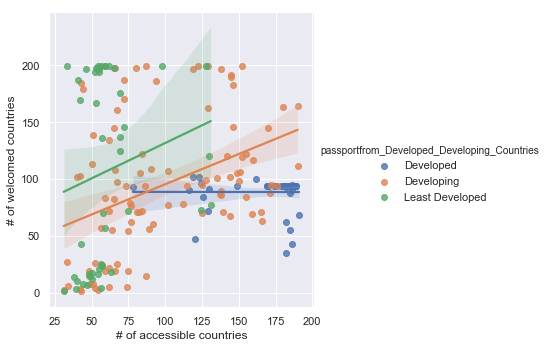

In [104]:
sns.set()

# Plot sepal with as a function of sepal_length across days
g = sns.lmplot(x="visafree", y="visafreeTO", hue="passportfrom_Developed_Developing_Countries",
               truncate=True, height=5, data=df_final)

# Use more informative axis labels than are provided by default
g.set_axis_labels("# of accessible countries", "# of welcomed countries")

## Correlation between sub-region and visa free

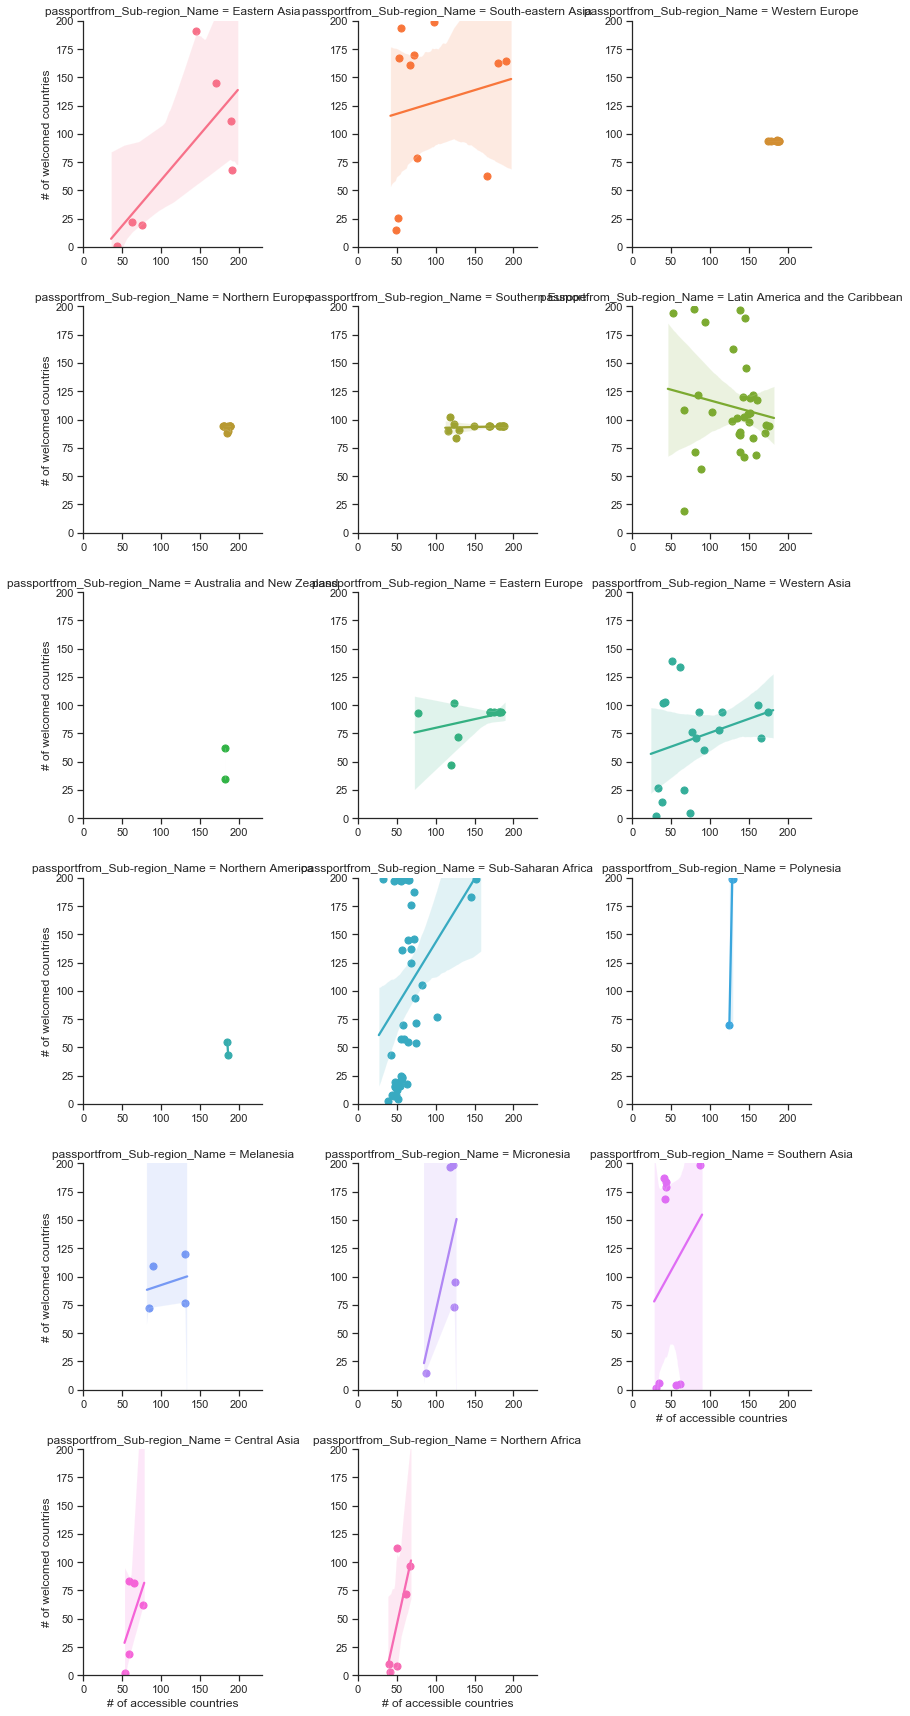

In [105]:
sns.set(style="ticks")

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="visafree", y="visafreeTO", col="passportfrom_Sub-region_Name", hue="passportfrom_Sub-region_Name", data=df_final,
               sharex=False,sharey=False,
               col_wrap=3,
               #ci=None, 
               #palette="muted",
               height=4,
               scatter_kws={"s": 50, "alpha": 1}
              )

# control x and y limits
g.set(ylim=(0, 200))
g.set(xlim=(0, 230))

# Use more informative axis labels than are provided by default
g.set_axis_labels("# of accessible countries", "# of welcomed countries")

## Heatmap of the new passport ranking

In [106]:
data = [ dict(
        type = 'choropleth',
        locations = df_final['country_alpha_3code'],
        z = df_final['New_Overall_ranking'],
        text = "<br />" + df_final['passportfrom_Country_name'] + "'s passport gives you access to"
                + "<br />" + df_final['visafree'].astype(int).astype(str) + " destinations visa-free (over " + str(df_visa_free['countryto_alpha_2code'].nunique()) + " possible)"
                + "<br /><br />" + "It ranks " +  df_final['New_Overall_ranking'].astype(int).astype(str) + " th overall, " + df_final['ranking_bySubRegion'].astype(int).astype(str) + " th in " + df_final['passportfrom_Sub-region_Name'] 
                + "<br /><br />That's a visa-free coverage of:"
                + "<br />" + (df_final['UN_World_GDP_percent'].astype(float)*100).astype(int).astype(str) + " % of the world's GDP"  
                + "<br />" + (df_final['UN_population_Value_2015_percent'].astype(float)*100).astype(int).astype(str) + " % of the world's population"
                + "<br />" + (df_final['Surface_area_covered_percent'].astype(float)*100).astype(int).astype(str) +  " % of the earth's land surface"
                + "<br />" + (df_final['unesco_total_sites_percent'].astype(float)*100).astype(int).astype(str) + " % of the Unesco's heritage sites"
                + "<br /><br />In " + df_final['passportfrom_Country_name'] + ", " + df_final['visafreeTO'].astype(int).astype(str) + " citizenships are welcomed visa-free"
                + "<br />" + "That's a ratio of " + df_final['visaFreeRatio'].astype(str),
        autocolorscale = True,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            tickmode = 'array',
            tickvals = [180,100,20],
            ticktext = ['Weak','Medium','Strong'],
            autotick = False,
            #tickprefix = 'test',
            title = 'Passport rank. 1 = best'),
      ) ]

layout = dict(
    title = 'Passport rank heatmap',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='passports-world-map1' )

C:\Users\Jrmy\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Heatmap of the gain/loss of ranking

In [129]:
data = [ dict(
        type = 'choropleth',
        locations = df_final['country_alpha_3code'],
        z = df_final['gain-loss'],
        text = df_final['passportfrom_Country_name'],
        autocolorscale = False,
        reversescale = False,
        colorscale = [[0, 'rgb(227,26,28,0.5)'], #red
                      [0.2, 'rgb(251,154,153,0.5)'], # salmon
                      [0.45, 'rgb(255,255,255,0.5)'], #white
                      [0.7, 'rgb(178,223,138,0.5)'], #light green
                      [1, 'rgb(51,160,44,0.5)']], #green
                       
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
    
        colorbar = dict(
            autotick = False,
            tickmode = 'array',
            #tickprefix = '',
            title = 'gain/loss'),
      ) ]

layout = dict(
    title = 'Passport rank gain/loss',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='passports-world-map3' )

C:\Users\Jrmy\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Heatmap visualization of the ratio countries accessibles vs countries welcomed visa-free

In [107]:
data = [ dict(
        type = 'choropleth',
        locations = df_final['country_alpha_3code'],
        z = df_final['visaFreeRatio'],
        text = "<br />" + df_final['passportfrom_Country_name'] + "'s passport gives you access to"
                + "<br />" + df_final['visafree'].astype(int).astype(str) + " destinations"
                + "<br /><br />" + df_final['visafreeTO'].astype(int).astype(str) + " citizenships are welcomed visa-free"
                + "<br /><br />" + "That's a ratio of " + round(df_final['visaFreeRatio'],1).astype(str),
        autocolorscale = False,
        reversescale = False,
        colorscale = [[0, 'rgb(51,160,44,0.5)'], #green
                      [0.05, 'rgb(178,223,138,0.5)'], #light green
                      [0.08, 'rgb(255,255,255,0.5)'], #white
                      [0.12, 'rgb(251,154,153,0.5)'], # salmon
                      [1, 'rgb(227,26,28,0.5)']], #red
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
    
        colorbar = dict(
            autotick = False,
            tickmode = 'array',
            #tickprefix = '',
            title = 'Ratio'),
      ) ]



layout = dict(
    title = 'ratio countries accessibles vs countries welcomed visa-free',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='passports-world-map2' )

C:\Users\Jrmy\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

